Part of the tutorial are from [https://www.kaggle.com/code/chriscc/mnist-mlp-pytorch/notebook](https://www.kaggle.com/code/chriscc/mnist-mlp-pytorch/notebook)

# Import pytorch libraries

In [160]:
import math
import torch
from torch import nn, optim, cuda
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn.functional as F
if cuda.is_available():
    # check if GPU is available
    print(cuda.get_device_properties(0))

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Steps to create a Neural Networks with Pytorch

1. Define a Neural Network (forward propagation)
2. Define dataset, data loader and transformations
3. Define optimizer and criterion
4. Train the model (back propagation)
5. Evaluate the model
6. Make prediction

# Step 1: Define a Neural Networks
The neural network architectures in Pytorch can be defined in a class which inherits the properties from the base class from **nn** package called Module. This inheritance from the nn.Module class allows us to implement, access, and call a number of methods easily. We can define all the layers inside the constructor of the class, and the forward propagation steps inside the forward function.

We will define a simple Multilayer Perceptron with the following architecture:

* Input layer
```Python
nn.Linear(28 * 28, 512)
```
    * Layer type: nn.Linear(), which refers to a fully connection layer
    * Input size: 28*28, corresponding to the size of input data.
    * Output size: 512, the number of "neurons".
    
* Hidden layer
```
nn.Linear(512, 256)
```

    * Layer type: nn.Linear()
    * Input size: 512, output size of the previous layer(input layer).
    * Output size: 256, the number of "neurons" in this layer.
    
* Output layer
```
nn.Linear(256, 10)
```

    * Layer type: nn.Linear()
    * Input size: 256, output size of the previous layer(hidden layer).
    * Output size: 10, the number of classes we need to predict.

* Activation functions
Each linear layer's output needs to go through an activation function to "activate" it. We will get started with **F.sigmoid()** but can try F.relu() or others later.

The best practice is to name each layer and initialize them in the **__init__()** function as named building blocks and put the building blocks together in the **forward()** function which defines how the data actually flows in the network. In our case, each layer simply takes the output of the previous layer and perform transformations the generate outputs in sequence.

In [4]:
class simpleNet(nn.Module):
    """
    A simple 3-layer fully connected neural network
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(simpleNet, self).__init__()
        self.layer1=nn.Linear(in_dim, n_hidden_1)
        self.layer2=nn.Linear(n_hidden_1, n_hidden_2)
        self.layer3=nn.Linear(n_hidden_2, out_dim)
    
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [5]:
class ActivationNet(nn.Module):
    """
    NN with activation
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(ActivationNet,self).__init__()
        #nn.Module(self).__init_()
        self.layer1=nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.ReLU(True))
        self.layer2=nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.ReLU(True))
        self.layer3=nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [6]:
class BatchNet(nn.Module):
    """
    NN with normalization
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(BatchNet, self).__init__()
        self.layer1=nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.layer2=nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3=nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        stride=1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=stride), # b 16, 26, 26
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=stride), # b, 32 ,24, 24
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # b, 32, 12, 12
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=stride), # b, 64, 10, 10
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=stride), #b, 128, 8, 8
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) #b, 128, 4, 4
        )
        # fully connection layer
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=x.view(x.size(0),-1)
        x=self.fc(x)
        return x

# Step 2: Define dataset, data loader and transformation

<!-- PyTorch gives use the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:
* the __len__ function which returns the size of the dataset, and
* the __getitem__ function which returns a sample from the dataset given an index.

However, in our case we can simply construct a TensorDataset with two items: the feature data and the target where the feature data is the matrix of pixel 1 - pixel 784 and the target is the digit of the image. -->


While the Dataset class is a nice way of containing data systematically, it seems that in a training loop, we will need to index or slice the dataset's samples list. This is no better than what we would do for a typical list or NumPy matrix. Rather than going down that route, PyTorch supplies another utility function called the DataLoader which acts as a data feeder for a Dataset object.


In order to construct the data loader we will need to provide two parameters: **batch_size** which indicates how many samples we want to use to train  the model in a batch, and **shuflle**, suggesting if we want to shuffle the data before sending it to the network. 

Typically we would want to set batch_size as $2^n$ e.g. 128, 256, 512, and set `shuffle` as `True` for traning data and `False` for validation and test data (you can take a moment to think why?)



### Download Datasets

In [59]:
from sklearn.model_selection import train_test_split

# preparing transforming functions
data_tf=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
# for rgb use transforms.Normalize([a,b,c],[d,e,f])
# download datasets into the data folder in upper level
train_dataset = datasets.MNIST(root='../data', train=True, transform=data_tf, download=True)
# dataset = datasets.MNIST(root='../data', train=True, transform=data_tf, download=True)
# x_train, x_val, y_train, y_val = train_test_split(
#     train.values[:,1:], train.values[:,0], test_size=0.2)

test_dataset = datasets.MNIST(root='../data', train=False, transform=data_tf, download=True)


### Load Datasets

In [162]:
# data loader
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display sample pictures from the dataset

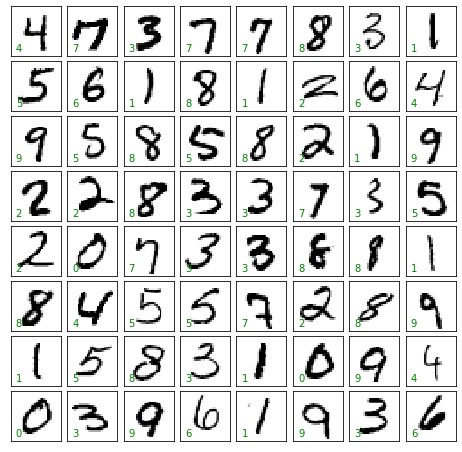

In [166]:
data=iter(train_loader)
samples,labels=data.next()

row_num=8 # if batch_size=64, plot matrix as 8x8
column_num=int(batch_size/row_num)


fig, axes = plt.subplots(row_num, column_num, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap='Greys', interpolation='nearest')
    ax.text(0.1, 0.1, labels[i].numpy(), transform=ax.transAxes, color='green')



# Step 3: Define optimizer and criterion

Optimizer is used to perform the gradient descent process. Here we will use SGD( Stochastic Gradient Descent). The tricky part is how to set the right size of learning rate which could have a huge impact on the final result. For now let's simply use 0.1 as the starting point but later we will revisit the options and strategies of learning rate selection.

Criterion will be used to calculate the cost (or loss) so we can use the cost to do back propagation and update the weights we want to train. In our case, we will use nn.CrossEntropyLoss() since we are working on a multiclassfication problem.

In [24]:
# define model
#model = simpleNet(28*28, 300, 100, 10)
model = BatchNet(28*28, 300, 100, 10)

num_epochs=20
if cuda.is_available(): 
    #if GPU is available
    model=model.cuda()

#---criterion is the cost or error function---
criterion=nn.CrossEntropyLoss()

#---optimizer for training the neural network---
# learning rate is step size when training the neural network
# larger step size trains quicker but may "miss" the optimal solution
learning_rate=1e-1
# use Adam optimizer
# you may try other optimizers such as SGD and Adagrad to see if accuracy improves
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
#optimizer=optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=optim.Adagrad(model.parameters(), lr=learning_rate)

# Step 4 train the model (back propagation)

Training the model is an iterative process which contains many epoches. For each epoch we will repeatly load batches of data, perform forward propagation, calculate cost, perform back propagation using the optimizer.

**Epoch** is how many times one wants to train the neural network. Each epoch will load and train all the training data through the neural network. After each epoch, the cost (error) function tends to get lower errors. Larger number of epoch means more rounds of training and may further lower the error of training but will take longer time. However, you may notice in the experiment that a very large number of epoch may not be necessary if the training error is "acceptable" after a lower number of rounds. 

In [27]:
%%time

## set number of epochs
num_epochs=20

##########training############
for epoch in range(num_epochs):
    train_loss=0
    for data in train_loader:
        img, label = data
        img = img.view(img.size(0),-1)
        if cuda.is_available(): # if GPU is available
            img=Variable(img).cuda()
            label=Variable(label).cuda()
        else:
            img=Variable(img)
            label=Variable(label)
        # forward training
        out = model(img)
        loss = criterion(out, label)
        train_loss += loss.data*label.size(0) 
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch+1)%(num_epochs/10) ==0:
        print(f'Epoch {epoch+1}/{num_epochs}, eval_loss={train_loss/(len(test_dataset))}')



Epoch 2/20, eval_loss=0.3523562252521515
Epoch 4/20, eval_loss=0.3270307779312134
Epoch 6/20, eval_loss=0.3505436182022095
Epoch 8/20, eval_loss=0.2893078625202179
Epoch 10/20, eval_loss=0.34159567952156067
Epoch 12/20, eval_loss=0.2945680320262909
Epoch 14/20, eval_loss=0.31438949704170227
Epoch 16/20, eval_loss=0.3226495087146759
Epoch 18/20, eval_loss=0.30969861149787903
Epoch 20/20, eval_loss=0.2742578387260437
CPU times: user 1min 3s, sys: 50.7 s, total: 1min 54s
Wall time: 1min 12s


# Step 5: Evaluate the model

We will use the trained model to make predictions on the validation dataset and compare the predictions against the actual targets. Dataloader will be used to iterate the validation dataset as well.

In [41]:
##########testing##########
eval_loss=0
eval_acc=0
#use evaluation model
model.eval()
for data in test_loader:
    img, label = data
    img = img.view(img.size(0),-1)
    if cuda.is_available(): #if GPU is available
        img=Variable(img).cuda()
        label=Variable(label).cuda()
    else:
        img=Variable(img)
        label=Variable(label)
    out = model(img)
    loss = criterion(out, label)
    eval_loss += loss.data*label.size(0)
    _, pred = torch.max(out, 1) #???
    num_correct = (pred==label).sum()
    eval_acc += num_correct.data
    #print('pred: {}, label: {}, num_correct: {}'.format(pred, label, num_correct))
print(f'Test Loss: {eval_loss/(len(test_dataset))}, Acc: {eval_acc*1.0/(len(test_dataset))}')


Test Loss: 0.14463278651237488, Acc: 0.9775000214576721


# Step 6: make prediction

This step is similar to the validation step except that we are not comparing the predictions as there's no ground truth of target to compare with.

In [169]:
model.eval() # prep model for evaluation

preds = []

for data in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    img, label = data
    img = img.view(img.size(0),-1)
    output = model(img)
    # calculate the loss
    _, pred = torch.max(output, 1)
    preds.extend(pred.tolist())
    # compare predictions to true label



In [44]:


#submission['Label'] = preds
#submission.to_csv('submission.csv', index=False)

NameError: name 'submission' is not defined

# Assignments:

1. Can you implment the following functions for model training, evaluation and prediction so we can reuse them when we need to test different things afterwards without having to replicate the codes every time.

```python

def train_model(nn_model, train_loader, optimizer, criterion, n_epoch):
    # YOUR IMPLEMENTATION
    return nn_model

def eval_model(nn_model, val_loader):
    # YOUR IMPLEMENTATION
    return calculated_accuracy


def predict(nn_model, test_loader):
    # YOUR IMPLEMENTATION
    return predictions

```


2. F.sigmoid() was used as the activation function for the MLP model we implemented. Can you try other activation functions such as F.relu() and F.tanh()? You may want to refer to the [PyTorch Functional](https://pytorch.org/docs/stable/nn.functional.html) for more details. Use the train_model(), eval_model() functions you implmented so you don't have to repeat the same codes.

3. Can you add a dropout layer between input and the hidden layer, and another one between the hidden layer and the output layer?

4. Try to add/ remove hiden layers, as well as different number of neurons and report your validation results.

5. Try different learning rate (0.0001, 0.001, 0.01, 0.1). What is your observation?

6. Try different values for batch_size(64, 128, 256, 512).

7. Try different values for n_epochs.

8. What can you think of if we want to improve the current model?

